Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [411]:
from random import random, seed
from itertools import product
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [412]:
# Instance 1
# UNIVERSE_SIZE = 100_000
# NUM_SETS = 10_000
# DENSITY = 0.3
UNIVERSE_SIZE = 1000
NUM_SETS = 100
DENSITY = 0.4
N_STEPS = 10000

MULTI_TWEAK = 0.015



rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [413]:
# DON'T EDIT THESE LINES!
SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [414]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    phenotype = np.logical_or.reduce(SETS[solution])
    return np.all(phenotype)


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [415]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(73047.00070144537))

In [416]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.True_, np.float64(36129.99701674989))

In [417]:
def tweak(solution:np.ndarray)->np.ndarray:
    new_sol = solution.copy()
    i = rng.integers(0,NUM_SETS)
    new_sol[i] = not new_sol[i]
    return new_sol

def multiple_mutation_tweak(solution:np.ndarray)->np.ndarray:
    mask = rng.random(NUM_SETS) < MULTI_TWEAK
    new_sol = np.logical_xor(solution,mask)
    return new_sol

In [418]:
def fitness(solution:np.ndarray):
    return (valid(solution),-cost(solution))

In [419]:
def simulated_annealing(f_cur_sol:np.ndarray,f_tweaked_sol:np.ndarray,temperature: np.float64) -> np.float64:
    """
    f_cur_sol: fitness of tweaked sol
    f_tweaked_sol: fitness of current sol
    temperature: parameter that balances the two solutions. Higher value favors exploration
    return: true if accepting a worsening solution
    """
    worse_p = np.exp(-(f_cur_sol-f_tweaked_sol)/temperature)
    # print("--")
    ic(f_cur_sol-f_tweaked_sol)
    ic(-(f_cur_sol-f_tweaked_sol)/temperature)
    ic(f_cur_sol)
    ic(f_tweaked_sol)
    ic(worse_p)
    is_accept = np.random.random() <= worse_p
    ic(is_accept) 
    # print("--")
    return is_accept

def new_starting_pos(best):
	if best is None:
		return np.random.random((NUM_SETS,)) <0.5
	else:
		return best


  0%|          | 0/10000 [00:00<?, ?it/s]

ic| fitness(solution): (np.True_, np.float64(-7120.971692454316))
ic| history.index(fitness(solution)[1]): 8363


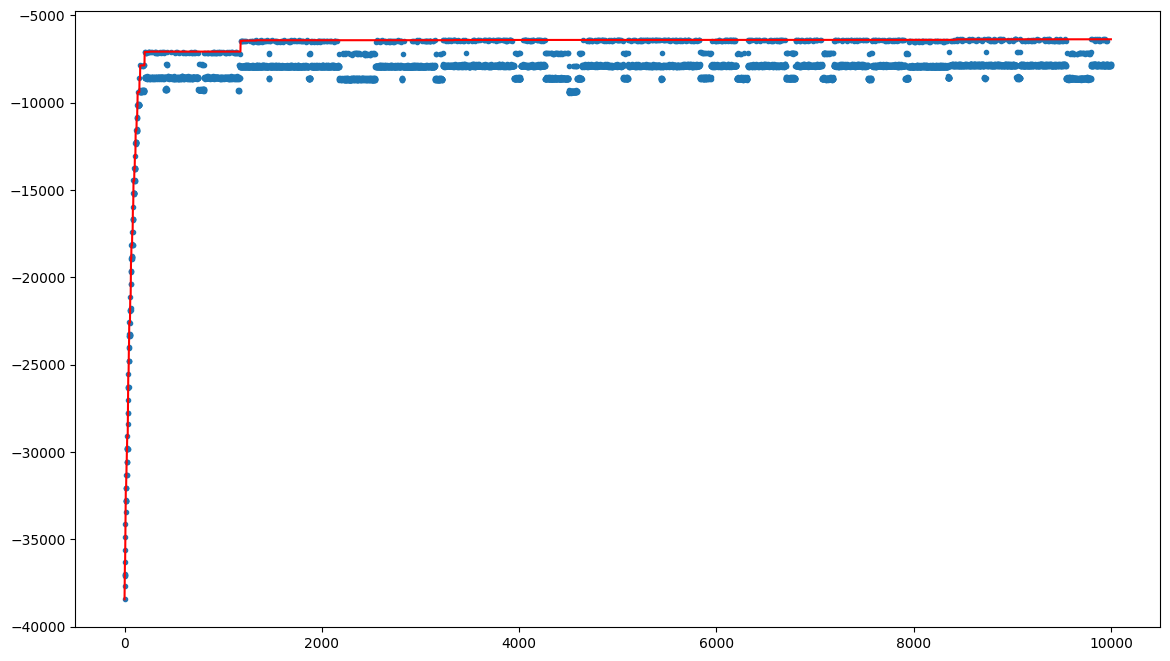

In [420]:
solution = rng.random(NUM_SETS) < 0.5
solution_fitness = fitness(solution)
history=[solution_fitness[1]]

STARTING_VALUE_TEMP = 0.5
temperature = STARTING_VALUE_TEMP
temp_threshold_restart = temperature*10

INC_VALUE = STARTING_VALUE_TEMP
best_sol_so_far = solution
# tweak=multiple_mutation_tweak
ic.disable()
for steps in tqdm(range(N_STEPS)):
    # print(f'Iterazione {steps}--------')
    new_solution = tweak(solution)
    ic(solution)
    ic(new_solution)
    f_newsol = fitness(new_solution)
    history.append(f_newsol[1])
    if  f_newsol>solution_fitness or ( f_newsol[0] and simulated_annealing(solution_fitness[1],f_newsol[1],temperature)) :
        solution=new_solution
        solution_fitness =  fitness(solution)
        # temperature= temperature -INC_VALUE if temperature >=0.1 else temperature
        temperature = STARTING_VALUE_TEMP
        ic(fitness(new_solution))
    else:
        temperature+= INC_VALUE

    # print(f'--------')
ic.enable()
ic(fitness(solution))
ic(history.index(fitness(solution)[1]))
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history),),
    [max(history[: i + 1]) for i in range(len(history))],
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")